In [9]:
import casadi as ca
from dynamics_hybrid import f
import numpy as np
import matplotlib.pyplot as plt

Impact at t=0.440s — velocities updated
Impact at t=1.000s — velocities updated


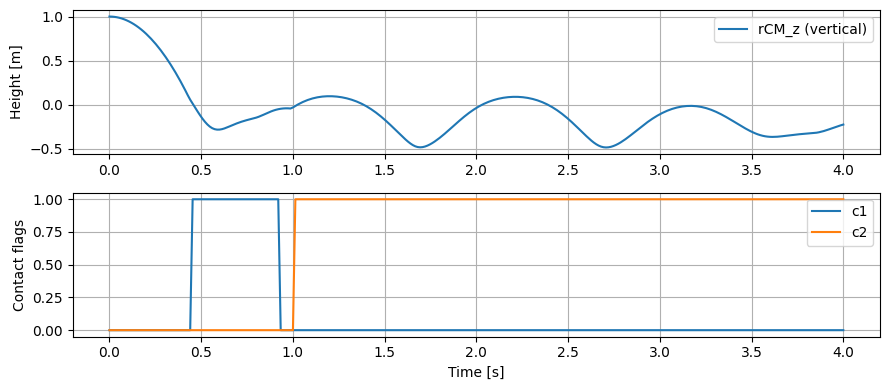

In [10]:
# ----------------------------
# Simulation setup
# ----------------------------
tf = 4.0          # total time [s]
N  = 300          # number of integration steps
dt = tf / N
ts = np.linspace(0, tf, N+1)

# ----------------------------
# Load your full dynamics function
# ----------------------------
# Make sure fdyn_total is imported from your CasADi file or module
# e.g.  from dynamics_hybrid import fdyn_total
f = f.expand()

# Extract symbolic inputs and outputs
x, u, p, c1, c2 = f.mx_in()
dxdt, lam_out, c1_new, c2_new, dq_plus = f(x, u, p, c1, c2)

# Wrap into callable function
Fdyn = ca.Function('Fdyn',
                   [x, u, p, c1, c2],
                   [dxdt, lam_out, c1_new, c2_new, dq_plus],
                   ['x','u','p','c1','c2'],
                   ['dxdt','lambda','c1_new','c2_new','dq_plus'])

# ----------------------------
# Build one-step RK integrator
# ----------------------------
# The integrator must know about c1, c2 → include them as extra parameters
ode = {'x': x, 'u': u, 'p': ca.vertcat(p, c1, c2), 'ode': dxdt}
intg = ca.integrator('intg', 'rk', ode, 0, dt, {'simplify': True})

# One-step map (x,u,p,c1,c2) -> x_next
res = intg(x0=x, u=u, p=ca.vertcat(p, c1, c2))
Fstep = ca.Function('Fstep',
                    [x, u, p, c1, c2],
                    [res['xf']],
                    ['x','u','p','c1','c2'],
                    ['xnext'])

# ----------------------------
# Parameters and initial conditions
# ----------------------------
p_val = ca.DM([1.0, 2.0, 0.5, 0, 1.5, 0.0, 9.81])  # [m, M, l, k, kappa, J, g]
x0 = ca.DM([0, 1, -np.pi/4, 3*np.pi/4, 0, 0.0, 0.0, 0.0])   # initial state (above ground)
u_val = 0.0                                              # no actuation
c1_val, c2_val = 0.0, 0.0                               # start in flight

# ----------------------------
# Storage arrays
# ----------------------------
X = np.zeros((N+1, x0.numel()))
LAM = np.zeros((N+1, 4))
C1 = np.zeros(N+1)
C2 = np.zeros(N+1)

X[0,:] = np.array(x0.T).flatten()
C1[0], C2[0] = c1_val, c2_val

# ----------------------------
# Hybrid simulation loop
# ----------------------------

# --- Simulation loop ---
xk = x0
for k in range(N):
    # Evaluate dynamics and contact logic
    out = Fdyn(xk, u_val, p_val, c1_val, c2_val)
    dxdt_k = out[0]
    lam_k  = out[1]
    c1_new = float(out[2])
    c2_new = float(out[3])
    dq_plus = out[4]

    # Check for impact (velocity discontinuity)
    dq = xk[4:8]
    if not np.allclose(np.array(dq_plus).flatten(),
                       np.array(dq).flatten(),
                       atol=1e-9):
        xk[4:8] = dq_plus
        print(f"Impact at t={ts[k]:.3f}s — velocities updated")

    # Integrate one time step
    xk = Fstep(xk, u_val, p_val, c1_val, c2_val)

    # Update contact flags for next step
    c1_val, c2_val = c1_new, c2_new

    # Log results
    X[k+1,:] = np.array(xk.T).flatten()
    LAM[k+1,:] = np.array(lam_k.T).flatten()
    C1[k+1], C2[k+1] = c1_val, c2_val

# ----------------------------
# Plot results
# ----------------------------
plt.figure(figsize=(9,4))
plt.subplot(2,1,1)
plt.plot(ts, X[:,1], label='rCM_z (vertical)')
plt.ylabel('Height [m]')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(ts, C1, label='c1')
plt.plot(ts, C2, label='c2')
plt.ylabel('Contact flags')
plt.xlabel('Time [s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tracking OCP: Which controls are necessary to make the angle between the rods vary sinusoidally?

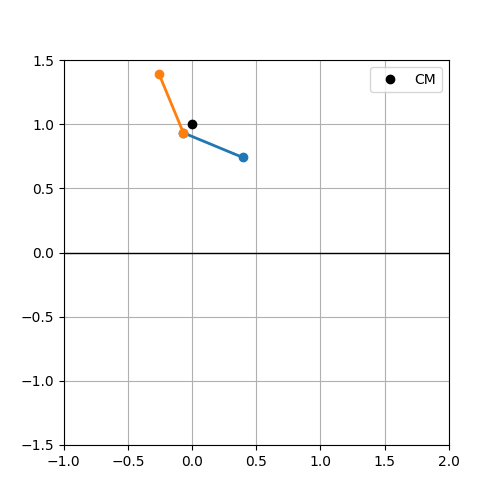

In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image

# ===============================================
#   2D Animation (saves as GIF and shows inline)
# ===============================================

# --- Forward kinematics (consistent with your dynamics) ---
rCMy, rCMz, qmean, qrel = ca.MX.sym('rCMy'), ca.MX.sym('rCMz'), ca.MX.sym('qmean'), ca.MX.sym('qrel')
q = ca.vertcat(rCMy, rCMz, qmean, qrel)

m, M, l, k, kappa, Jpar, g = ca.MX.sym('m'), ca.MX.sym('M'), ca.MX.sym('l'), ca.MX.sym('k'), ca.MX.sym('kappa'), ca.MX.sym('Jpar'), ca.MX.sym('g')
p = ca.vertcat(m, M, l, k, kappa, Jpar, g)

phi1 = qmean - 0.5*qrel
phi2 = qmean + 0.5*qrel

rBy = rCMy + 2*m*l/(M+2*m)*ca.sin(qmean)*ca.cos(qrel/2)
rBz = rCMz - 2*m*l/(M+2*m)*ca.cos(qmean)*ca.cos(qrel/2)
r1y = rBy - l*ca.sin(phi1)
r1z = rBz + l*ca.cos(phi1)
r2y = rBy - l*ca.sin(phi2)
r2z = rBz + l*ca.cos(phi2)

fk_fun = ca.Function('fk_fun', [q, p], [rBy, rBz, r1y, r1z, r2y, r2z])

# --- Evaluate forward kinematics for each time step ---
YB, ZB, Y1, Z1, Y2, Z2 = [], [], [], [], [], []
for k in range(len(ts)):
    qk = X[k, [0,1,2,3]]   # [rCMy, rCMz, qmean, qrel]
    yb, zb, y1, z1, y2, z2 = fk_fun(qk, p_val)
    YB.append(float(yb)); ZB.append(float(zb))
    Y1.append(float(y1)); Z1.append(float(z1))
    Y2.append(float(y2)); Z2.append(float(z2))

YB, ZB, Y1, Z1, Y2, Z2 = map(np.array, (YB,ZB,Y1,Z1,Y2,Z2))

# --- Setup figure and artists ---
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(-1, 2)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid(True)
ax.axhline(0, color='k', lw=1)

leg1, = ax.plot([], [], 'o-', lw=2, color='tab:blue')
leg2, = ax.plot([], [], 'o-', lw=2, color='tab:orange')
cm_pt, = ax.plot([], [], 'ko', ms=6, label='CM')
contact_dot1, = ax.plot([], [], 'ro', ms=5)
contact_dot2, = ax.plot([], [], 'ro', ms=5)
ax.legend()

# --- Animation init and update functions ---
def init():
    leg1.set_data([], []); leg2.set_data([], [])
    cm_pt.set_data([], []); contact_dot1.set_data([], []); contact_dot2.set_data([], [])
    return leg1, leg2, cm_pt, contact_dot1, contact_dot2

def update(i):
    leg1.set_data([YB[i], Y1[i]], [ZB[i], Z1[i]])
    leg2.set_data([YB[i], Y2[i]], [ZB[i], Z2[i]])
    cm_pt.set_data([float(X[i,0])], [float(X[i,1])])

    if C1[i] > 0.5:
        contact_dot1.set_data([float(Y1[i])], [0.0])
    else:
        contact_dot1.set_data([], [])
    if C2[i] > 0.5:
        contact_dot2.set_data([float(Y2[i])], [0.0])
    else:
        contact_dot2.set_data([], [])
    return leg1, leg2, cm_pt, contact_dot1, contact_dot2

ani = FuncAnimation(fig, update, frames=len(ts),
                    init_func=init, blit=True, interval=dt * 1000, repeat=False)

# --- Save to GIF and display inline ---
gif_path = "motion.gif"
ani.save(gif_path, writer='pillow', fps=int(1/dt))
plt.close(fig)  # avoid duplicate static figure

# Display the animation inline (PyCharm Jupyter)
Image(filename=gif_path)


In [12]:
#define tracking function (ref)
tf = 5
N = 20
ts = np.linspace(0,tf,N+1).T
ref = ca.cos(2*np.pi*ts/tf)

#load dynamics function as an ode
f = f.expand()
[x,u,p,c1,c2] = f.mx_in()
dyn = {'x':x,'u':u,'p':p,'ode':f(x,u,p,c1,c2)}

#define a function F that maps the current state to the next
dt = tf/N
intg = ca.integrator('intg','rk',dyn,0,dt,{'simplify':True})
res = intg(x0=x,u=u,p=p)
F = ca.Function('F',
                [x,u,p,c1,c2],[res['xf']],
                ['x','u','p'],['xnext'])

#decision variables
opti = ca.Opti()
X = opti.variable(4,N+1) #(qmean,qrel,dqmean,dqrel)x(N+1)
U = opti.variable(1,N)
P = opti.parameter(6)
opti.set_value(P,ca.vertcat(1,2,1,0,1,0)) #p=(m,M,l,k,kappa,J)

#objective function
opti.minimize(ca.sumsqr(X[1,:].T-ref))

#define constraints
#opti.subject_to(-1 <= (U <= 1))
for k in range(N):
    opti.subject_to( F(X[:,k],U[:,k],P) - X[:,k+1] == 0 ) #continuity of state variables

#initial guess
opti.set_initial(X, np.zeros((4,N+1)))
opti.set_initial(U, np.zeros((1,N)))

NotImplementedError: Wrong number or type of arguments for overloaded function 'integrator'.
  Possible prototypes are:
    integrator(str,str,dict:SX,dict)
    integrator(str,str,dict:MX,dict)
    integrator(str,str,Function,dict)
    integrator(str,str,dict:SX,float,[float],dict)
    integrator(str,str,dict:SX,float,float,dict)
    integrator(str,str,dict:MX,float,[float],dict)
    integrator(str,str,dict:MX,float,float,dict)
    integrator(str,str,Function,float,[float],dict)
    integrator(str,str,Function,float,float,dict)
  You have: '(str,str,str:(MX,MX,MX,MX,MX)|MX,int,float,str:bool)'


In [4]:
opti.solver('ipopt')
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      420
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      201

Total number of variables............................:      104
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       80
Total number of inequality c

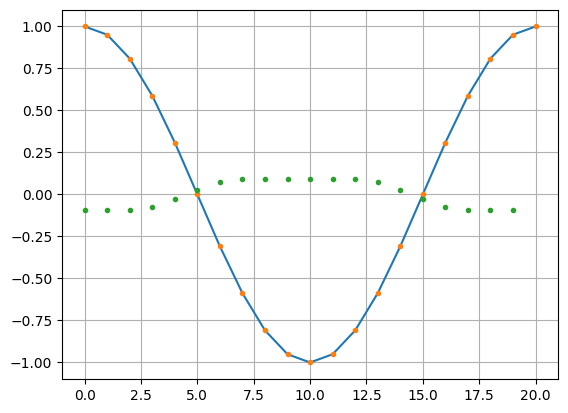

In [5]:
import matplotlib.pyplot as plt
qmean,qrel,dqmean,dqrel = sol.value(X)
tau = sol.value(U)
plt.figure()
plt.plot(ref,label='ref')
plt.plot(qrel,'.',label='qrel')
plt.plot(tau,'.',label='tau')
plt.grid()